In [52]:
#"""
#***********************************************************************
#************** Author:   Christian KEMGANG NGUESSOP *******************
#************** Project:   churn-insight             *******************
#************** Version:  1.0.0                      *******************
#***********************************************************************
#"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
import shap

# ----------------------------
# 1. Chargement et exploration
# ----------------------------
# Recréation du DataFrame à partir des données fournies
data = pd.read_csv("churn_clients.csv")

print("=== Aperçu des données ===")
print(f"Nombre de clients : {len(data)}")
print(f"Colonnes : {list(data.columns)}")
print("\n5 premières lignes :\n", data.head())

=== Aperçu des données ===
Nombre de clients : 500
Colonnes : ['Age', 'Revenu', 'Sexe', 'Anciennete', 'Frequence_utilisation', 'Support_contacte', 'Score_satisfaction', 'Resilie']

5 premières lignes :
    Age  Revenu   Sexe  Anciennete  Frequence_utilisation Support_contacte  \
0   56    4343  Femme           8                     23              Oui   
1   69    5070  Homme           9                     26              Oui   
2   46    1580  Femme           8                     10              Non   
3   32    8004  Homme           9                     29              Oui   
4   60    9130  Homme           9                      1              Non   

   Score_satisfaction  Resilie  
0                   2        0  
1                   2        0  
2                   3        0  
3                   3        0  
4                   1        0  


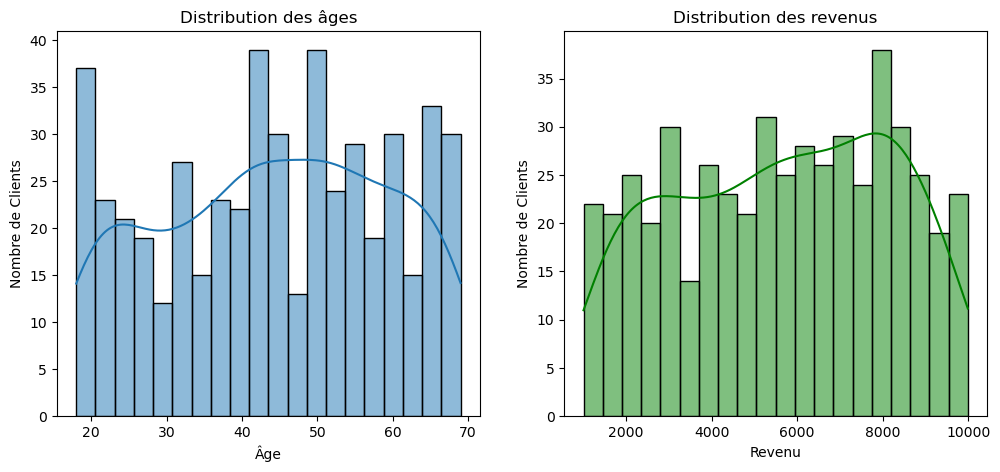

In [53]:
# ----------------------------
# 2. Visualisation des données
# ----------------------------
plt.figure(figsize=(12, 5))

# Histogrammes
plt.subplot(1, 2, 1)
sns.histplot(data['Age'], kde=True, bins=20)
plt.title('Distribution des âges')
plt.xlabel('Âge')
plt.ylabel('Nombre de Clients')

plt.subplot(1, 2, 2)
sns.histplot(data['Revenu'], kde=True, bins=20, color='green')
plt.title('Distribution des revenus')
plt.xlabel('Revenu')
plt.ylabel('Nombre de Clients')

plt.show()

In [54]:
# ----------------------------
# 3. Nettoyage et préparation
# ----------------------------
# Encodage des variables catégorielles
le = LabelEncoder()
data['Sexe'] = le.fit_transform(data['Sexe']) # 0:Femme, 1:Homme
data['Support_contacte'] = le.fit_transform(data['Support_contacte']) # 0:Non, 1:Oui

# Normalisation des variables numériques
scaler = StandardScaler()
num_cols = ['Age', 'Revenu', 'Anciennete', 'Frequence_utilisation']
data[num_cols] = scaler.fit_transform(data[num_cols])

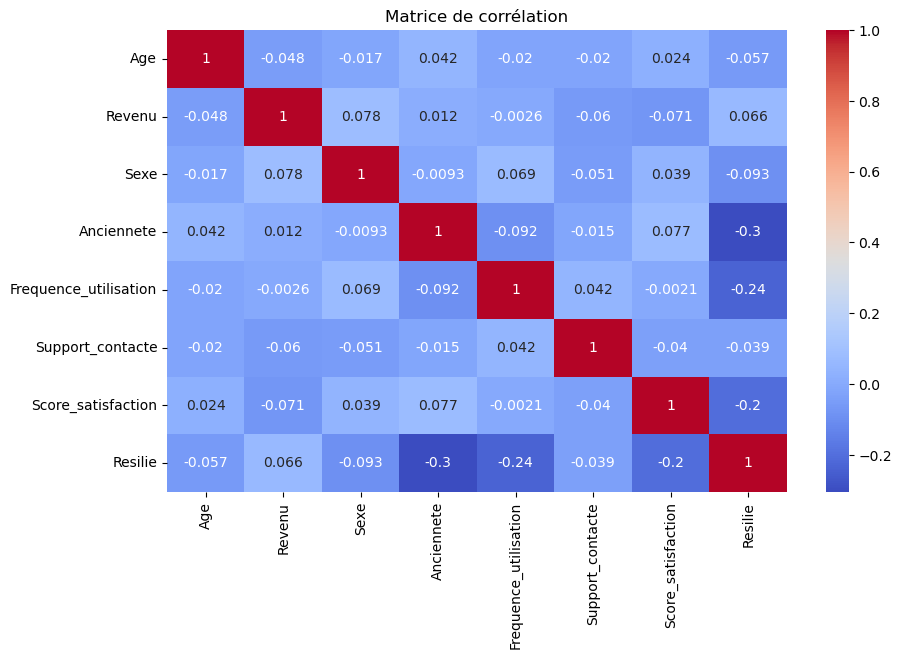

In [55]:
# Matrice de corrélation
corr_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()


In [64]:
from sklearn.model_selection import learning_curve
# ----------------------------
# 4. Modélisation
# ----------------------------
# Séparation des données
X = data.drop('Resilie', axis=1)
y = data['Resilie']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fonction d'évaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Précision : {accuracy_score(y_test, y_pred):.2f}")
    print(f"Rappel : {recall_score(y_test, y_pred):.2f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.2f}")
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title('Matrice de confusion')
    plt.show()


=== Régression Logistique ===
Précision : 0.99
Rappel : 1.00
F1-score : 0.89


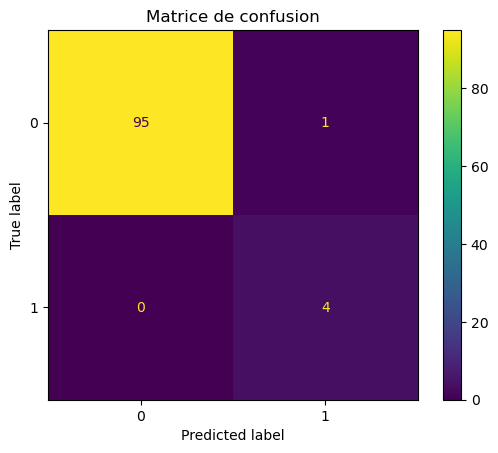

In [65]:
# Modèles de base
print("\n=== Régression Logistique ===")
lr = LogisticRegression()
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test)


=== Arbre de Décision ===
Précision : 1.00
Rappel : 1.00
F1-score : 1.00


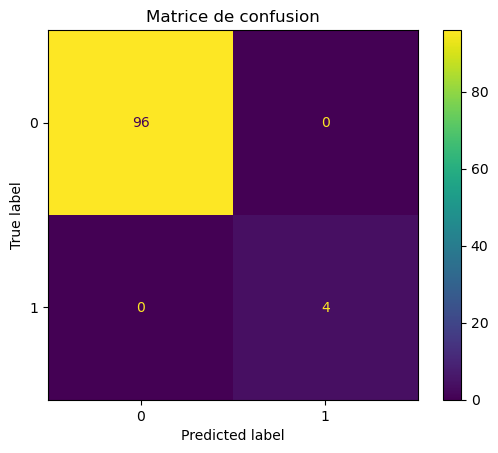

In [66]:
# Modèles de base
print("\n=== Arbre de Décision ===")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
evaluate_model(dt, X_test, y_test)



=== KNN (k=5) ===
Précision : 0.99
Rappel : 1.00
F1-score : 0.89


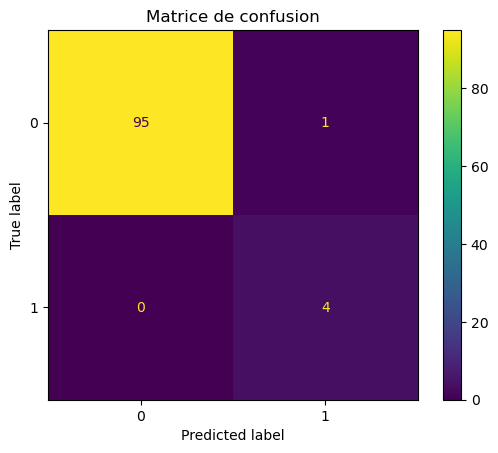

In [67]:
# Modèles de base
print("\n=== KNN (k=5) ===")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
evaluate_model(knn, X_test, y_test)

In [68]:
# ----------------------------
# 5. Optimisation du modèle
# ----------------------------
# Validation croisée pour l'arbre
scores = cross_val_score(dt, X, y, cv=5, scoring='f1')
print(f"\nF1-score moyen (CV) : {np.mean(scores):.2f} ± {np.std(scores):.2f}")

# GridSearch pour l'arbre
params = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(dt, params, cv=5, scoring='f1')
grid.fit(X, y)
print(f"\nMeilleurs paramètres : {grid.best_params_}")
print(f"Meilleur F1-score : {grid.best_score_:.2f}")



F1-score moyen (CV) : 1.00 ± 0.00

Meilleurs paramètres : {'max_depth': 3, 'min_samples_split': 2}
Meilleur F1-score : 1.00


In [69]:
# ----------------------------
# 6. Interprétation
# ----------------------------
# Importance des caractéristiques
dt_optimized = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_optimized.fit(X_train, y_train)

features = X.columns
importances = dt_optimized.feature_importances_
pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)

,Feature,Importance
4,Frequence_utilisation,0.557021
6,Score_satisfaction,0.234535
3,Anciennete,0.208443
2,Sexe,0.000000
1,Revenu,0.000000
0,Age,0.000000
5,Support_contacte,0.000000


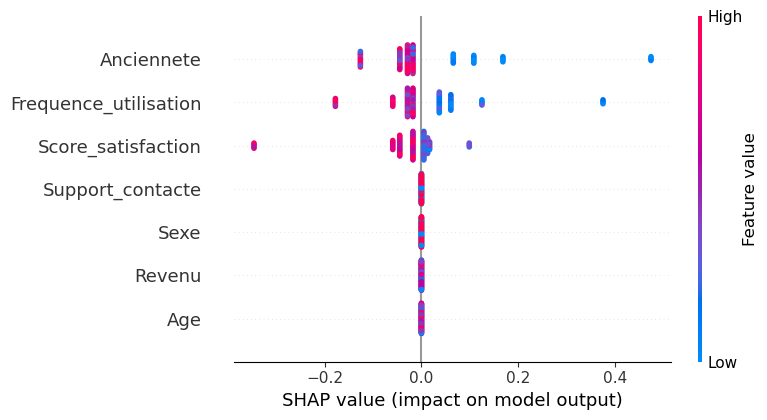

In [70]:
# Exemple SHAP
explainer = shap.TreeExplainer(dt_optimized)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=features)

In [32]:
# -------------------------------------------------
# Export du modèle et des préprocesseurs
# -------------------------------------------------
import joblib

# Sauvegarder le modèle et les données
joblib.dump(dt_optimized, "model.pkl")
data.to_csv('processed_data.csv', index=False)

# Sauvegarder le scaler (si vous avez normalisé les données)
joblib.dump(scaler, "scaler.pkl")

# Sauvegarder les encodeurs (si vous avez des variables catégorielles)
joblib.dump(le, "label_encoder.pkl")

print("Export du modèle et des préprocesseurs effectués avec succès!")

Export du modèle et des préprocesseurs effectués avec succès!
